# Chapter 1: Load and work with a sample dataset 

## 1.1 Load modules and libraries and set parameters 

In [1]:
# import modules and libraries and set parameters 


import geopandas
import geopy
import h5py
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import pandas.testing as tm
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from termcolor import colored
import us


# plot colors (Vega 10 palette) and properties 
blue = "#1f77b4"
orange = "#ff7f0e"
green =  "#2ca02c"
red = "#d62728"
purple = "#9467bd"
brown = "#8c564b"
pink = "#e377c2"
gray = "#7f7f7f"
cyan = "#17becf"
black = "#000000"

LW = 5                 # line width
FS = 24                # font size
FN = 'times new roman' # font name

font = {'family':'serif', 'size':FS}
plt.rc('text', usetex=True) 
plt.rc('font', **font)

## 1.2 Load city IDs and show a sample city 

In [2]:
# load the list of cities and show results for a sample city  


nMonths = 12
nDays = 366


# load the list of cities and their IDs 
mainDir = 'us_cities_temp_prcp/'
cities = pd.read_csv(mainDir + '/city_info_recent.csv')
nCities, _ = cities.shape

city = input("city name: ") 

# Capitalize the city name (if it is not already) 
city = city.capitalize()

# find the city row and then the city ID 
idx = cities['Name'][cities['Name']==city.capitalize()].index[0]
cityid = cities['ID'][idx]
print('city id :', cityid)


# load daily data
# set the dates as index. 
# This is necessary for further processing such as resampling by month
sampleData = pd.read_csv(mainDir + cityid + '.csv', index_col='Date', parse_dates=['Date'])
if 'Unnamed: 0' in sampleData:
    del sampleData['Unnamed: 0']
    
# estimate the mean temperature
sampleData['tmean'] = 0.5*(sampleData['tmin'] + sampleData['tmax']) 

# create new column for the day of the year: 1-366, where 1 is January 1st
# index must be converted to series, so the day of the year can be calculated
sampleData['day'] = sampleData.index.to_series().dt.dayofyear
print('\n',sampleData.head(5))

city name: lander
city id : USW00024021

             tmax  tmin  prcp  tmean  day
Date                                    
1892-01-01  32.0  -5.0  0.00   13.5    1
1892-01-02  38.0   2.0  0.00   20.0    2
1892-01-03  50.0  16.0  0.00   33.0    3
1892-01-04  46.0  32.0  0.00   39.0    4
1892-01-05  21.0  10.0  0.16   15.5    5


## 1.3 Clean and Resample data 

                 tmax       tmin      prcp      tmean  month
Date                                                        
1892-01-01  30.806452   2.774194  0.024194  16.790323      1
1892-02-01  40.137931  11.517241  0.015517  25.827586      2
1892-03-01  46.451613  22.387097  0.040323  34.419355      3
1892-04-01  49.800000  24.900000  0.137667  37.350000      4
1892-05-01  59.096774  34.354839  0.110968  46.725806      5
1892-06-01  72.700000  42.100000  0.039333  57.400000      6
1892-07-01  83.451613  48.903226  0.066129  66.177419      7
1892-08-01  82.677419  46.516129  0.027742  64.596774      8
1892-09-01  77.466667  40.600000  0.002000  59.033333      9
1892-10-01  60.516129  27.967742  0.033226  44.241935     10
1892-11-01  47.500000  19.566667  0.038333  33.533333     11
1892-12-01  29.258065   2.322581  0.051613  15.790323     12


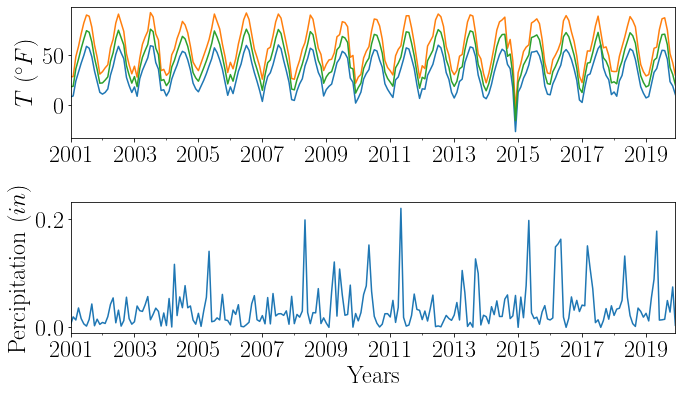

In [3]:
# resample data and calculate average over each month and save them to the start of the month (MS)
# create new column of the month of the year: 1-12, where 1 is January

sDate= '2001-01-01'
eDate = '2019-12-31'

reSampleData = sampleData.resample('MS').mean()
del reSampleData['day']
reSampleData['month'] = reSampleData.index.to_series().dt.month

# find the average data for the same month over the years
reSampleDataMean = reSampleData.groupby('month').mean()

# fill null values by interplation
reSampleData = reSampleData.interpolate()
print(reSampleData.head(nMonths))

fig, axes = plt.subplots(2, 1, figsize=(10, 6))

reSampleData[sDate:eDate].plot(ax=axes[0], y=['tmin', 'tmax', 'tmean'], legend=False)
axes[0].set_ylabel('$T$ ($^\circ F$)')
axes[0].set_xlabel('')

reSampleData[sDate:eDate].plot(ax=axes[1], y=['prcp'], legend=False)
axes[1].set_ylabel('Percipitation ($in$)')
axes[1].set_xlabel('Years')
plt.tight_layout()
plt.show()

## 1.4 Decompose yearly weather data into: 1-seasonal, 2-trend, and 3-residual components. 
This step is not necessary for the processing, but provdides important information

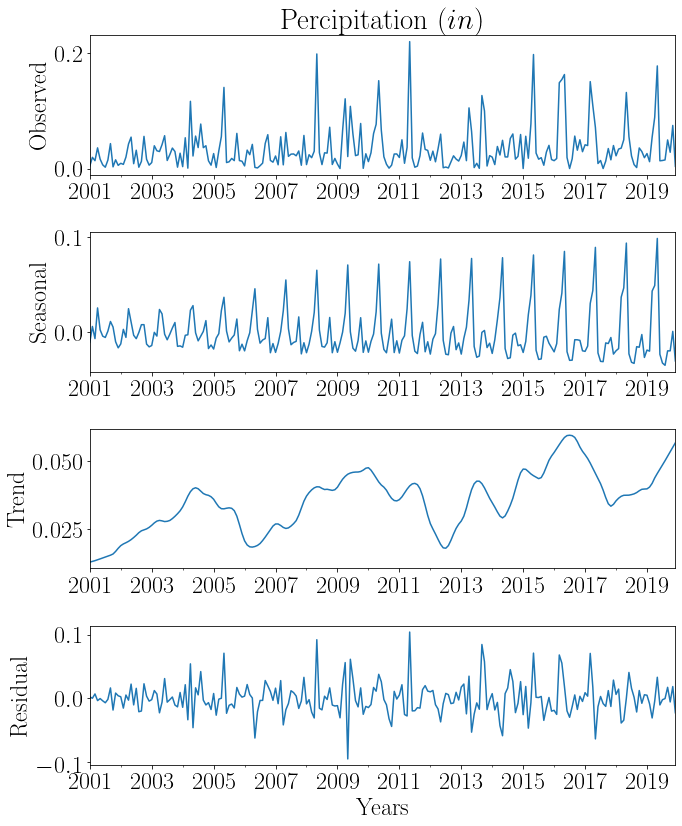

In [4]:
# seasonal decomposition of percipitation 

Pdecomp = STL(reSampleData['prcp'][sDate:eDate], period=nMonths, seasonal=13).fit()

fig, axes = plt.subplots(4, 1, figsize=(10, 12))

Pdecomp.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
axes[0].set_xlabel('')
axes[0].set_title('Percipitation ($in$)')

Pdecomp.seasonal.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Seasonal')
axes[1].set_xlabel('')

Pdecomp.trend.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Trend')
axes[2].set_xlabel('')

Pdecomp.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Years')

plt.tight_layout()
plt.show()

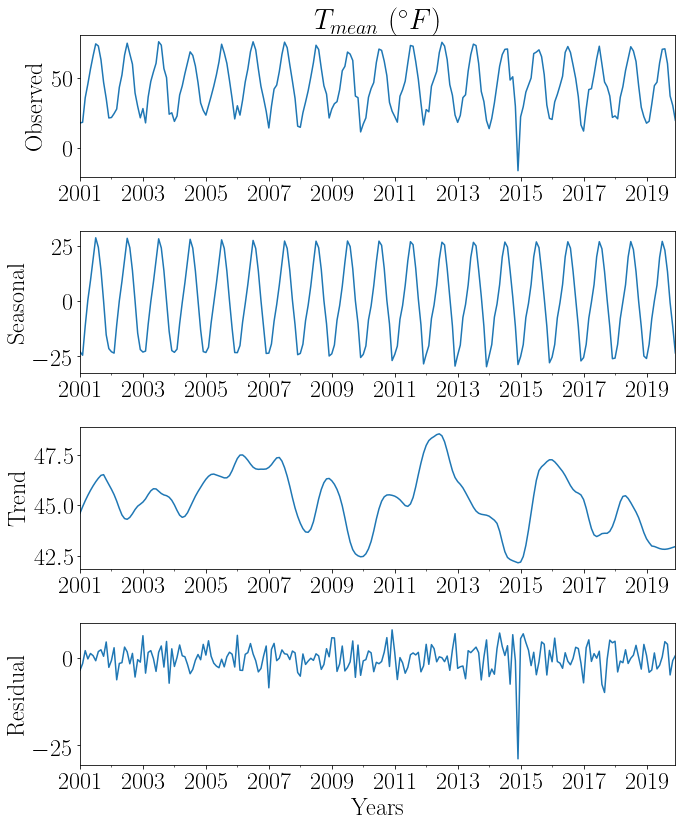

In [5]:
# seasonal decomposition of mean temperature  

Tdecomp = STL(reSampleData['tmean'][sDate:eDate], period=nMonths, seasonal=13).fit()

fig, axes = plt.subplots(4, 1, figsize=(10, 12))

Tdecomp.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
axes[0].set_xlabel('')
axes[0].set_title('$T_{mean}$ ($^\circ F$)')

Tdecomp.seasonal.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Seasonal')
axes[1].set_xlabel('')

Tdecomp.trend.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Trend')
axes[2].set_xlabel('')

Tdecomp.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Years')

plt.tight_layout()
plt.show()

## 1.5 Find parameters for the forecast model: Seasonal Arima (Sarima): (p, d, q)x(P, D, Q, m) 
        

### Model:
**SARIMA** is a **Seasnal(S) AutoRegressive (AR) integrated (I) Moving Average (MA)**:

* **AR** uses the dependent relationship between an observation and some number of lagged observations.

* **I** uses differencing of raw observations (e.g. subtracting an observation from observation at the previous time step) in order to make the time series stationary.

* **MA** uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

### Parameters:
* p and seasonal P: indicate the number of AR terms (lags of the stationary series)
* d and seasonal D: indicate differencing that must be done to stationary series
* q and seasonal Q: indicate the number of MA terms (lags of the forecast errors)
* m: indicates the seasonal length in the data

### The process to determine parameters 
1. **m:** identify the seasonal length m (plot ACF and there will be peaks at lags = m) => m = 12
2. **D:** remove seaonality by differentiating the t.s and the seasonally shifted (t.s) and check if stationary: ts_ns = ts - ts.shift(D*m), where D = [1, 2, ...]. Take the minimum value of D that makes data stationary
3. **d:** remove trend from seasonally stationary data by differentiating and use AD FUller test to verify: ts_ns_nt = ts_ns - ts_ns.shift(d), where d = [1, 2, ...]. Take the minimum value of d that makes data stationary 
4. **p and P:** use ACF plot of ts_ns_nt, initial spikes at lag = p and seasonal spikes at lag = m*P, which means a probable AR order of p and seasonal AR order of P 
5. **q and Q:** use PACF plot of ts_ns_nt, initial spikes at lag = q and seasonal spikes at lag = m*Q, which means a probable AR order of q and seasonal AR order of Q 

Once m, D, and d are found, one can run an ompitimzation routine for a range of p, P, q, and Q and find the best values

In [6]:
# set dates for the model 

# train dates
sD = '2001-01-01'
eDtemp = '2015-12-01'

# observed dates
sDtemp = '2016-01-01'
eD = '2019-12-01'

ADF Statistic of raw data: -2.827990
p-value: 0.054386 

ADF Statistic of data with no seasonality: -5.976692
p-value: 0.000000 

m = 1
D = 1


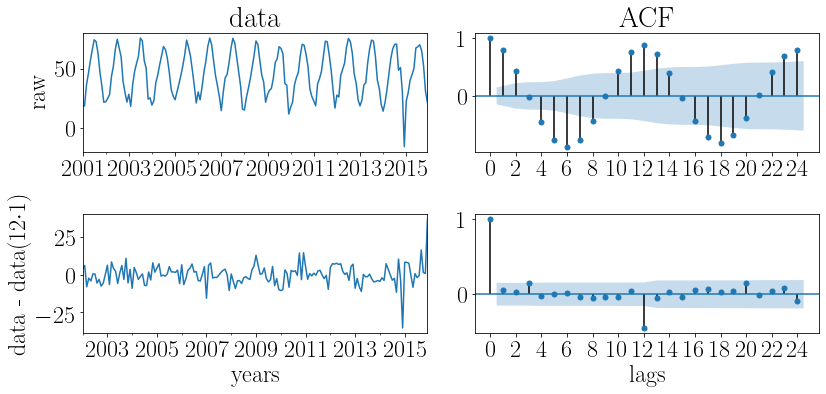

In [7]:
# step 1: find m and D 

# raw data
data = reSampleData['tmean'][sD:eDtemp]
result = adfuller(data)
print('ADF Statistic of raw data: %f' % result[0])
print('p-value: %f \n' % result[1])

# data with no seasonality  
data_ns = data - data.shift(12*1)
data_ns = data_ns.dropna()
result = adfuller(data_ns)
print('ADF Statistic of data with no seasonality: %f' % result[0])
print('p-value: %f \n' % result[1])
print('m = 1')
print('D = 1')

fig, axes = plt.subplots(2, 2, figsize=(12,6))
data.plot(ax = axes[0, 0])
axes[0, 0].set_title('data')
axes[0, 0].set_ylabel('raw')
axes[0, 0].set_xlabel('')

plot_acf(data, lags = 24, ax = axes[0, 1]);
axes[0, 1].set_title('ACF')
axes[0, 1].set_ylabel('')
axes[0, 1].set_xlabel('')
axes[0, 1].set_xticks(np.arange(0,26,2))


data_ns.plot(ax = axes[1, 0])
axes[1, 0].set_ylabel('data - data(12$\cdot$1)')
axes[1, 0].set_xlabel('years')

plot_acf(data_ns, lags=24, ax = axes[1, 1]);
axes[1, 1].set_title('')
axes[1, 1].set_ylabel('')
axes[1, 1].set_xlabel('lags')
axes[1, 1].set_xticks(np.arange(0,26,2))
plt.tight_layout()

ADF Statistic of no season data: -5.976692
p-value: 0.000000 

ADF Statistic of no season no trend data: -5.827442
p-value: 0.000000 

One could choose d = 0 based on this sample dataset
I choose d = 1, beacuse it better represents the majority of all cities


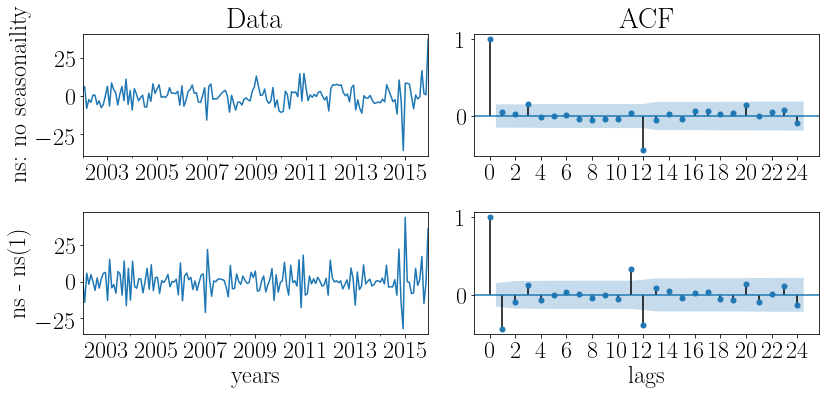

In [8]:
# step 2: find d 

# data with no seasonaility  
data_ns = data - data.shift(12*1)
data_ns = data_ns.dropna()
result = adfuller(data_ns)
print('ADF Statistic of no season data: %f' % result[0])
print('p-value: %f \n' % result[1])

# data with no seasonal nor regular trend 
data_ns_nt = data_ns - data_ns.shift(1)
data_ns_nt = data_ns_nt.dropna()
result = adfuller(data_ns_nt)
print('ADF Statistic of no season no trend data: %f' % result[0])
print('p-value: %f \n' % result[1])
print('One could choose d = 0 based on this sample dataset')
print('I choose d = 1, beacuse it better represents the majority of all cities')


fig, axes = plt.subplots(2, 2, figsize=(12,6))
data_ns.plot(ax = axes[0, 0])
axes[0, 0].set_title('Data')
axes[0, 0].set_ylabel('ns: no seasonaility')
axes[0, 0].set_xlabel('')

plot_acf(data_ns, lags = 24, ax = axes[0, 1]);
axes[0, 1].set_title('ACF')
axes[0, 1].set_ylabel('')
axes[0, 1].set_xlabel('')
axes[0, 1].set_xticks(np.arange(0,26,2))


data_ns_nt.plot(ax = axes[1, 0])
axes[1, 0].set_ylabel('ns - ns(1)')
axes[1, 0].set_xlabel('years')

plot_acf(data_ns_nt, lags=24, ax = axes[1, 1]);
axes[1, 1].set_title('')
axes[1, 1].set_ylabel('')
axes[1, 1].set_xlabel('lags')
axes[1, 1].set_xticks(np.arange(0,26,2))
plt.tight_layout()

An initial spike at lag = 0 of the ACF of the sampele data suggests p = 0
I chosoe p = 1, beacuse it better represents the majority of all cities
A seasonal spikes at lag = 12*1 of the ACF of the sample data suggests P = 1

An initial spike at lag = 0 of the PACF of the sampele data suggests q = 0
I choose q = 1, beacuse it better represents the majority of all cities
A seasonal spikes at lag = 12*1 of the PACF of the sample data suggests Q = 1


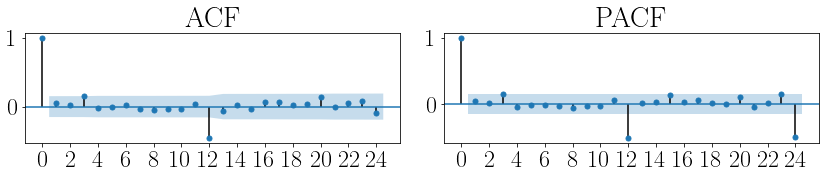

In [9]:
# step 3 find p, P and q, Q 

print('An initial spike at lag = 0 of the ACF of the sampele data suggests p = 0')
print('I chosoe p = 1, beacuse it better represents the majority of all cities')
print('A seasonal spikes at lag = 12*1 of the ACF of the sample data suggests P = 1\n')


print('An initial spike at lag = 0 of the PACF of the sampele data suggests q = 0')
print('I choose q = 1, beacuse it better represents the majority of all cities')
print('A seasonal spikes at lag = 12*1 of the PACF of the sample data suggests Q = 1')

    
fig, axes = plt.subplots(1, 2, figsize=(12,3))

plot_acf(data_ns, lags = 24, ax = axes[0]);
axes[0].set_title('ACF')
axes[0].set_ylabel('')
axes[0].set_xlabel('')
axes[0].set_xticks(np.arange(0,26,2))

plot_pacf(data_ns, lags = 24, ax = axes[1]);
axes[1].set_title('PACF')
axes[1].set_ylabel('')
axes[1].set_xlabel('')
axes[1].set_xticks(np.arange(0,26,2))
plt.tight_layout()

## 1.6 Create the model with the determined parameters 

In [10]:
# create the model with the following parameters using train data 
# SARIMA (p, d, q)x(P, D, Q, m): (1, 1, 1)x(1, 1, 1, 12)


p, d, q = 1, 1, 1  
P, D, Q, m = 1, 1, 1, 12


train_data = reSampleData['tmean'][sD:eDtemp]
test_data = reSampleData['tmean'][sDtemp:eD]

Tmodel = sm.tsa.statespace.SARIMAX(reSampleData['tmean'][sD:eDtemp], order=(p, d, q), seasonal_order=(P, D, Q, m))
Tresults = Tmodel.fit(method = 'powell')

Pmodel = sm.tsa.statespace.SARIMAX(reSampleData['prcp'][sD:eDtemp], order=(p, d, q), seasonal_order=(P, D, Q, m))
Presults = Pmodel.fit(method = 'powell')

Optimization terminated successfully.
         Current function value: 2.871246
         Iterations: 5
         Function evaluations: 360
Optimization terminated successfully.
         Current function value: -1.819250
         Iterations: 5
         Function evaluations: 359


## 1.7 Forecast data using the model

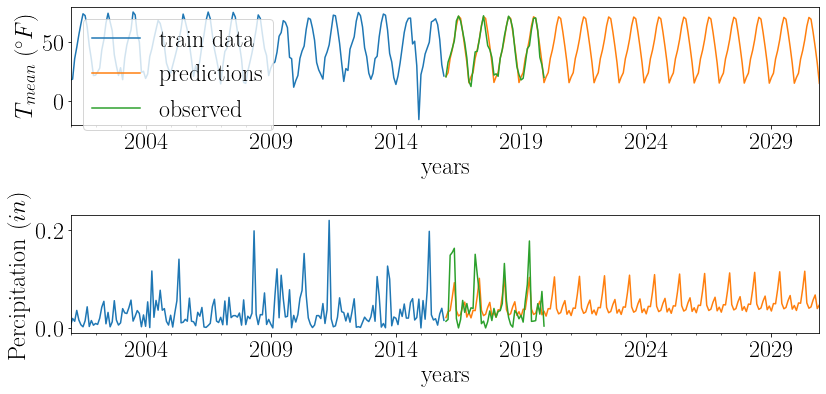

In [11]:
# forecast data and compare it with test data 

start = len(train_data) 
# or start ='2016-01-01'

#end = len(train_data) + len(test_data) - 1
end ='2030-12-01'
  
# Predictions for one-year against the test set 
Tpredictions = Tresults.predict(start, end, typ = 'levels').rename('predictions') 
Ppredictions = Presults.predict(start, end, typ = 'levels').rename('predictions') 



# plot predictions and actual values 
fig, axes = plt.subplots(2, 1, figsize=(12,6))
reSampleData['tmean'][sD:eDtemp].plot(ax = axes[0], label = 'train data')
Tpredictions.plot(ax = axes[0]) 
reSampleData['tmean'][sDtemp:eD].plot(ax = axes[0], label = 'observed') 
axes[0].set_ylabel('$T_{mean}$ ($^\circ F$)')
axes[0].set_xlabel('years')
axes[0].legend()

reSampleData['prcp'][sD:eDtemp].plot(ax = axes[1], label = 'train data')
Ppredictions.plot(ax = axes[1]) 
reSampleData['prcp'][sDtemp:eD].plot(ax = axes[1], label = 'observed') 
axes[1].set_ylabel('Percipitation ($in$)')
axes[1].set_xlabel('years')
#axes[0].legend()

plt.tight_layout()

# Chapter 2: Load all cities, fit model and predict data for 2020-2070

## 2.1: Define a function to load data, fit model and save results 

In [12]:
# define a module to load, process and forecast data  

def load_and_model(df, startDate, endDate, startModel, endModel, p, d, q, P, D, Q, m):
    ## inputs:
    # df: dataframe containing the daily temperature and percipitation data
    # startDate: start date of the train data (i.e. '2001-01-01')
    # endDate: end date of the train data (i.e. '2019-12-01')
    # startModel: start date of the model (i.e. '2020-01-01')
    # endModel: end date of the model (i.e. '2050-12-01')
    # p, d, q, P, D, Q, m: Seasonal ARIMA model parameters (i.e., 1, 1, 1, 1, 1, 1, 12)
    
    ## outputs:
    # Tpredictions: predicted temperature time series
    # Ppredictions: predicted percipitation time series
    
    # load daily data
    # make the dates the correct format and set them as index. 
    # This is necessary for further manipulations such as resampling by month
    if 'Unnamed: 0' in df:
        del df['Unnamed: 0']

    # estimate the mean temperature
    df['tmean'] = 0.5*(df['tmin'] + df['tmax']) 
    
    # create new column of the day of the year: 1-366, where 1 is January 1st
    # index must be converted to series, so the day of the year can be calculated
    df['day'] = df.index.to_series().dt.dayofyear

    # resample data and calculate average over each month and save them to the start of the month (MS)
    # create new column of the month of the year: 1-12, where 1 is January
    reSampleData = df.resample('MS').mean()
    reSampleData['month'] = reSampleData.index.to_series().dt.month
    del reSampleData['day']

    # fill null values by interplation
    reSampleData = reSampleData.interpolate()
    
    # create the SARIMA model and fit to predict temperature and percipittion
    Tmodel = sm.tsa.statespace.SARIMAX(reSampleData['tmean'][startDate:endDate], order=(p, d, q), seasonal_order=(P, D, Q, m))
    Tresults = Tmodel.fit(method = 'powell', disp=0)
    Tpredict = Tresults.predict(startModel, endModel, typ = 'levels').rename('predictions') 
    
    Pmodel = sm.tsa.statespace.SARIMAX(reSampleData['prcp'][startDate:endDate], order=(p, d, q), seasonal_order=(P, D, Q, m))
    Presults = Pmodel.fit(method = 'powell', disp=0)
    Ppredict= Presults.predict(startModel, endModel, typ = 'levels').rename('predictions')     
    
    return Tpredict, Ppredict

In [ ]:
# NO NEED TO RUN: the data is saved to an HDF file 
# load, process and forecast data and write forecast to a file 

citiesMaster = pd.read_csv(mainDir + 'city_info_recent_all.csv')
nCities, _ = citiesMaster.shape

# startDate: start date of the train data (i.e. '2001-01-01')
# endDate: end date of the train data (i.e. '2019-12-01')
startDate = '2001-01-01'
endDate = '2019-12-01'

# startModel: start date of the model (i.e. '2020-01-01')
# endModel: end date of the model (i.e. '2050-12-01')
startModel = '2020-01-01'
endModel = '2070-12-01'

# convert to date type
dtsModel = datetime.strptime(startModel, '%Y-%m-%d')
dteModel = datetime.strptime(endModel, '%Y-%m-%d')

# p, d, q, P, D, Q, m: Seasonal ARIMA model parameters (i.e., 1, 1, 1, 1, 1, 1, 12)
p, d, q = 1, 1, 1  
P, D, Q, m = 1, 1, 1, 12

forecast = {}
pars = ['ID', 'city', 'state', 'Lat', 'Lon', 'zipcode', 'tmean', 'prcp']
for ii in range(nCities):
    cityID = citiesMaster['ID'][ii]
    df = pd.read_csv(mainDir + 'cities/' + cityID + '.csv', index_col='Date', parse_dates=['Date'])
    
    Tpredict, Ppredict = load_and_model(df, startDate, endDate, startModel, endModel, p, d, q, P, D, Q, m)
    
    forecast[cityID] = {}
    for jj in range(len(pars) - 2):
        forecast[cityID][pars[jj]] = citiesMaster[pars[jj]][ii]   
    forecast[cityID]['tmean'] = Tpredict
    forecast[cityID]['prcp'] = Ppredict
    
# save data to HDf5 file
hf = h5py.File(mainDir + '/' + 'forecast_' + str(dtsModel.year) + '_' + str(dteModel.year) + '.h5', 'w')
for ii in range(nCities): 
    cityID = citiesMaster['ID'][ii]
    for jj in range(len(pars)):
        hf.create_dataset(citiesMaster['ID'][ii] + '/' + pars[jj], data=forecast[cityID][pars[jj]])
hf.close()

# Chapter 3: Take info from user and find the best match

## 3.1 Load saved forecast data 

In [13]:
# load forecast data 

# Us states geometries and data  
mapDir = 'us_map/'
USmap = geopandas.read_file(mapDir + 'usa-states-census-2014.shp')
citiesMaster = pd.read_csv(mainDir + 'city_info_recent_all.csv')
nCities, _ = citiesMaster.shape
nMonths = 12


# p, d, q, P, D, Q, m: Seasonal ARIMA model parameters (i.e., 1, 1, 1, 1, 1, 1, 12)
p, d, q = 1, 1, 1  
P, D, Q, m = 1, 1, 1, 12

pars = ['ID', 'city', 'state', 'Lat', 'Lon', 'zipcode', 'tmean', 'prcp']
dates = pd.date_range('2020-01-01', '2070-12-01', freq='MS')
forecast = {}
hf = h5py.File('forecast_2020_2070.h5', 'r')
for ii in range(nCities): 
    cityID = citiesMaster['ID'][ii]
    forecast[cityID] = {}
    for jj in range(len(pars)-2):
        forecast[cityID][pars[jj]] = hf[citiesMaster['ID'][ii] + '/' + pars[jj]][()]
    for jj in range(6, len(pars)):
        temp = hf[citiesMaster['ID'][ii] + '/' + pars[jj]][()]
        forecast[cityID][pars[jj]] = pd.DataFrame(temp, index=dates, columns=[pars[jj]])
hf.close()

## 3.2 Accept city, state and date from user 

In [14]:
# choose date, state and city 

print('\n enter a year between 2020 and 2070')

year = 0
while  year < 2020 or year > 2070:
    if year is not 0:
        print('date is out of range\n')
    year = int(input('prediction year: '))

    
print('\n enter a state')
state = 'AA'
while us.states.lookup(state) not in us.STATES:
    if state is not 'AA':
        print('state was not found\n')
    state = input("state: ") 
state = us.states.lookup(state).name

    
print('\n enter one of the avilable cities/towns for the state of ', state)
print(list(citiesMaster['city'][citiesMaster['state']==state]))
city = None
while city not in list(citiesMaster['city']):
    if city is not None:
        print('city was not found\n')
    city = input("city/town: ") 
    city = city.title() 
zipcode = citiesMaster['zipcode'][(citiesMaster['city']==city) & (citiesMaster['state']==state)].item()
futureID = citiesMaster['ID'][(citiesMaster['city']==city) & (citiesMaster['state']==state)].item()

factor = None
while factor not in ('temperature', 'percipitation', 'both'):
    if factor is not None:
        print('parameter was not found')
    print('\n enter the parameter to compare: "temperature", "percipitation", or "both"')
    factor = input('parameter: ')


print('\n Your choice: ', city, ', ', state, str(zipcode).zfill(5), 'in ', str(year)) 


 enter a year between 2020 and 2070
prediction year: 2070

 enter a state
state: ma

 enter one of the avilable cities/towns for the state of  Massachusetts
['Worcester', 'Milton', 'Boston']
city/town: worcester

 enter the parameter to compare: "temperature", "percipitation", or "both"
parameter: both

 Your choice:  Worcester ,  Massachusetts 01524 in  2070


## 3.3 Find the best match


 Worcester, Massachusetts 01524 in 2070 will be similar to  Belvidere, New Jersey 07823 in 2020


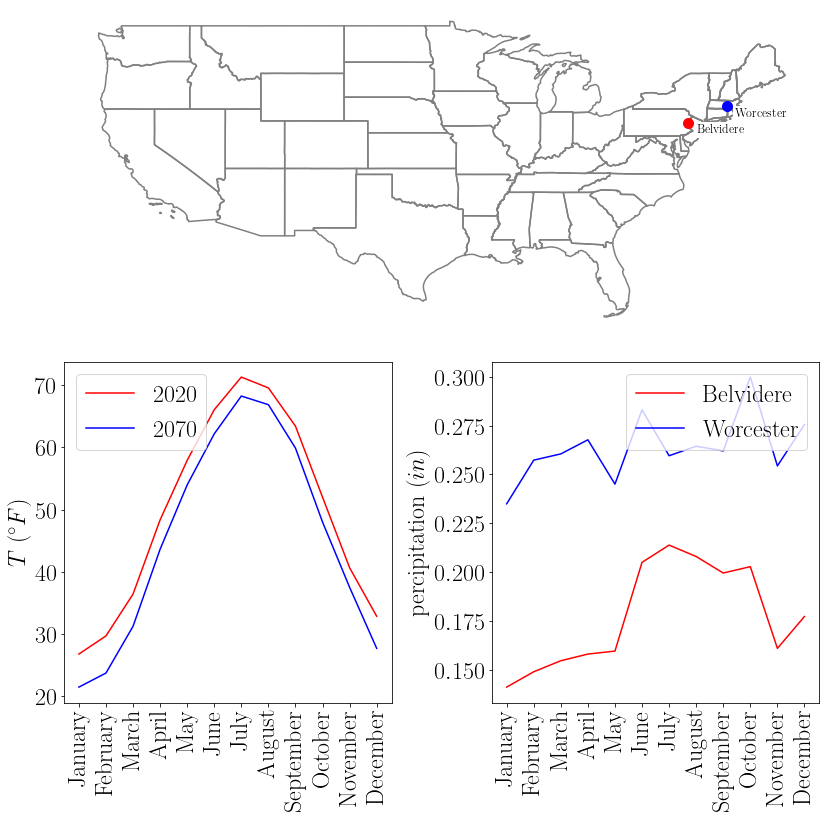

In [15]:
# calculate the temperature and percipitation residuals and find the best match to "current" year

yearNow = 2020

Tfuture = forecast[futureID]['tmean'][str(year)]
Pfuture = forecast[futureID]['prcp'][str(year)]

months = Tfuture.index.strftime('%B')

Tresidual = np.zeros(nCities)
Presidual = np.zeros(nCities)
TPresidual = np.zeros(nCities)
for ii in range(nCities):
    ID = citiesMaster['ID'][ii]
    
    T = forecast[ID]['tmean'][str(yearNow)]
    Troot = pd.DataFrame((Tfuture.values - T.values)**2, columns=Tfuture.columns, index=Tfuture.index)
    Tresidual[ii] = np.sqrt(Troot.mean()).values/np.array(Tfuture.mean())
    
    P = forecast[ID]['prcp'][str(yearNow)]
    Proot = pd.DataFrame((Pfuture.values - P.values)**2, columns=Pfuture.columns, index=Pfuture.index)
    Presidual[ii] = np.sqrt(Proot.mean()).values/np.array(Pfuture.mean())
    
    TPresidual[ii] = 0.5*(Tresidual[ii] + Presidual[ii])


if factor == 'temperature':
    minInd = np.argmin(Tresidual)
elif factor == 'percipitation':
    minInd = np.argmin(Presidual)
else:  
    minInd = np.argmin(TPresidual)
    
nowID = citiesMaster['ID'][minInd]
Tnow = forecast[nowID]['tmean'][str(yearNow)]
Pnow = forecast[nowID]['prcp'][str(yearNow)]

print('\n', colored(city+ ', '+ state+ ' ' +str(zipcode).zfill(5)+' in '+ str(year), 'blue'), 
      'will be similar to ', 
      colored(forecast[nowID]['city']+ ', '+ forecast[nowID]['state']+ ' ' + str(forecast[nowID]['zipcode']).zfill(5)+' in '+ str(yearNow), 'red'))      

fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2, 2, (1,2))
USmap.boundary.plot(ax = ax1, color = 'gray')
plt.axis('off')
plt.plot(forecast[nowID]['Lon'], forecast[nowID]['Lat'], 'o', color = 'red', markersize = 10)
plt.plot(forecast[futureID]['Lon'], forecast[futureID]['Lat'], 'o', color = 'blue', markersize = 10)
x1 = forecast[nowID]['Lon']
y1 = forecast[nowID]['Lat']
x2 = forecast[futureID]['Lon']
y2 = forecast[futureID]['Lat']
dx = x2-x1
dy = y2-y1
plt.annotate(city, (0.99*x2, 0.98*y2), backgroundcolor='w', fontsize = 0.5*FS, xycoords='data')
plt.annotate(forecast[nowID]['city'] , (0.99*x1, 0.98*y1), backgroundcolor='w', fontsize = 0.5*FS, xycoords='data')

ax2 = fig.add_subplot(2, 2, 3)
plt.plot(np.arange(nMonths), np.array(Tnow), label = str(yearNow), color='red')
plt.plot(np.arange(nMonths), np.array(Tfuture), label = str(year), color='blue')
plt.legend(loc='upper left')
plt.ylabel('$T$ ($^\circ F$)')
plt.xticks(np.arange(nMonths), months, rotation='vertical')

ax3 = fig.add_subplot(2, 2, 4)
plt.plot(np.arange(nMonths), np.array(Pnow), label = forecast[nowID]['city'], color='red')
plt.plot(np.arange(nMonths), np.array(Pfuture), label = forecast[futureID]['city'], color='blue')
plt.legend(loc='upper right')
plt.ylabel('percipitation ($in$)')
plt.xticks(np.arange(nMonths), months, rotation='vertical')

plt.tight_layout()
plt.show()